In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier


In [4]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

In [5]:
from sklearn.inspection import permutation_importance

import shap

In [6]:
df = pd.read_csv('healthcare-stroke-data.csv')

df['gender'] = (df['gender'] == 'Male') * 1.  # 1 Male | 0 Female
df['ever_married'] = (df['ever_married'] == 'Yes') * 1.0
df['residence_type'] = (df['Residence_type'] == 'Urban') * 1.0
df.drop(['Residence_type'], axis=1, inplace=True)

df_train, df_test = train_test_split(df, test_size=.25, random_state=26)
df_train, df_valid = train_test_split(df_train, test_size=.3, random_state=26)

len(df_train), len(df_valid), len(df_test)

(2682, 1150, 1278)

In [7]:
df_train['stroke'].value_counts().to_frame(name='count').assign(percentage=lambda x: x['count'] / x['count'].sum() * 100).round(2)


,count,percentage
stroke,,
0,2548,95.0
1,134,5.0


In [8]:
df_train.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
avg_glucose_level,0
bmi,98
smoking_status,0


In [9]:
bmi_median = df_train['bmi'].median()
df_train['bmi2'] = df_train['bmi'].fillna(bmi_median)
df_valid['bmi2'] = df_valid['bmi'].fillna(bmi_median)
print(bmi_median)

28.0


In [10]:
# Separate features and target
X_train, y_train = df_train.drop('stroke', axis=1), df_train['stroke'].values
X_valid, y_valid = df_valid.drop('stroke', axis=1), df_valid['stroke'].values

In [11]:
X_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,residence_type,bmi2
2393,54172,0.0,41.0,0,0,1.0,Private,140.93,46.5,Unknown,1.0,46.5
3535,29792,0.0,49.0,0,0,1.0,Private,85.23,25.4,Unknown,0.0,25.4
923,72020,1.0,71.0,0,1,1.0,Self-employed,207.32,32.4,smokes,0.0,32.4
1604,25107,0.0,47.0,0,0,1.0,Private,65.04,30.9,never smoked,1.0,30.9
3670,63282,0.0,51.0,0,0,1.0,Govt_job,92.95,23.9,never smoked,0.0,23.9


In [12]:
cols_cat = df_train.select_dtypes(include=['object', 'category']).columns.values.tolist()
cols_num = df_train.select_dtypes(include=['number']).columns.values

print(f'categorical columns: {", ".join(cols_cat)}')
print(f'numerical columsn: {", ".join(cols_num)}')

categorical columns: work_type, smoking_status
numerical columsn: id, gender, age, hypertension, heart_disease, ever_married, avg_glucose_level, bmi, stroke, residence_type, bmi2


In [13]:
cols_num = list(set(cols_num) - {'id', 'bmi', 'stroke'})
cols_num

['heart_disease',
 'age',
 'ever_married',
 'bmi2',
 'residence_type',
 'hypertension',
 'avg_glucose_level',
 'gender']

In [14]:
X_train[cols_cat].head()

,work_type,smoking_status
2393,Private,Unknown
3535,Private,Unknown
923,Self-employed,smokes
1604,Private,never smoked
3670,Govt_job,never smoked


In [15]:
# One-hot encode categorical features (fit on train, transform on both)
encoder_1hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = pd.DataFrame(encoder_1hot.fit_transform(X_train[cols_cat]))
X_valid_cat = pd.DataFrame(encoder_1hot.transform(X_valid[cols_cat]))

# Get the feature names (one-hot encoded column names) from the encoder
categories = encoder_1hot.categories_

# Generate new column names with the category as a prefix
new_column_names = []
for i, col in enumerate(cols_cat):
    category_names = categories[i]
    for cat in category_names:
        new_column_names.append(f"{col}__{cat.lower().replace(' ', '_')}")

X_train_cat.columns = new_column_names
X_valid_cat.columns = new_column_names

In [16]:
# Drop original categorical columns and concatenate encoded ones
X_train.drop(cols_cat, axis=1, inplace=True)
X_valid.drop(cols_cat, axis=1, inplace=True)


In [17]:
X_train = pd.concat([X_train[cols_num].reset_index(drop=True), X_train_cat], axis=1)
X_valid = pd.concat([X_valid[cols_num].reset_index(drop=True), X_valid_cat], axis=1)

In [18]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [19]:
# Predictions and metrics
pred_valid = rf.predict(X_valid)
proba_valid = rf.predict_proba(X_valid)[:, 1]

accuracy = accuracy_score(y_valid, pred_valid)
roc_auc = roc_auc_score(y_valid, proba_valid)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.9478
ROC AUC: 0.8269


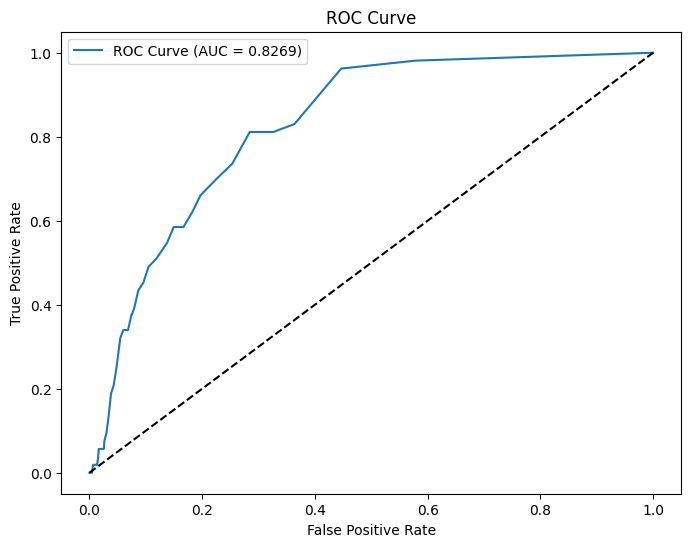

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_valid, proba_valid)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

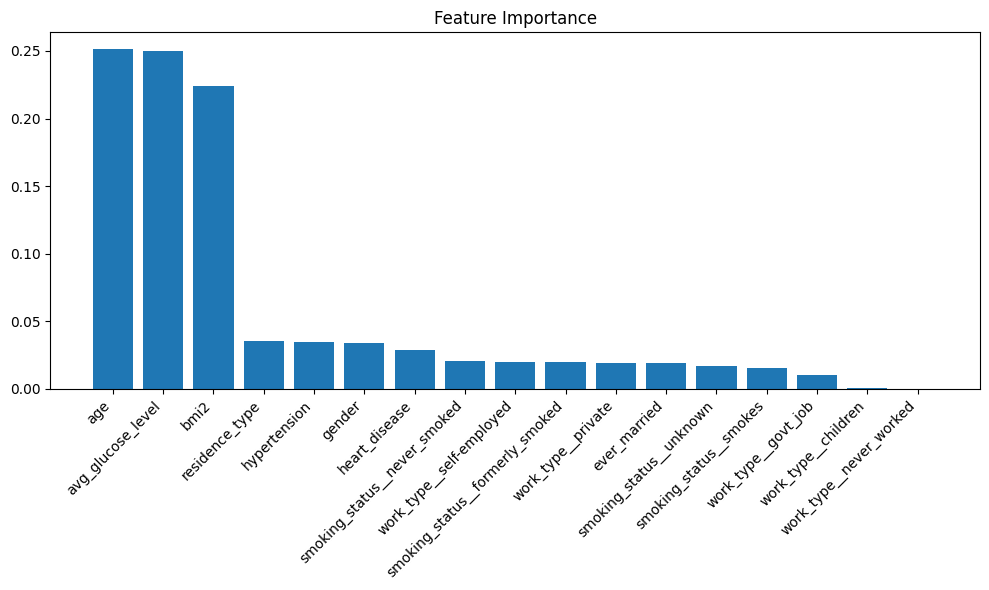

In [21]:
# Feature Importance
plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
# feature_names = df.drop('stroke', axis=1).columns.tolist()
# feature_names.extend(encoder_1hot.get_feature_names_out(cols_cat))
sorted_indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[sorted_indices], tick_label=np.array(X_train.columns)[sorted_indices])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


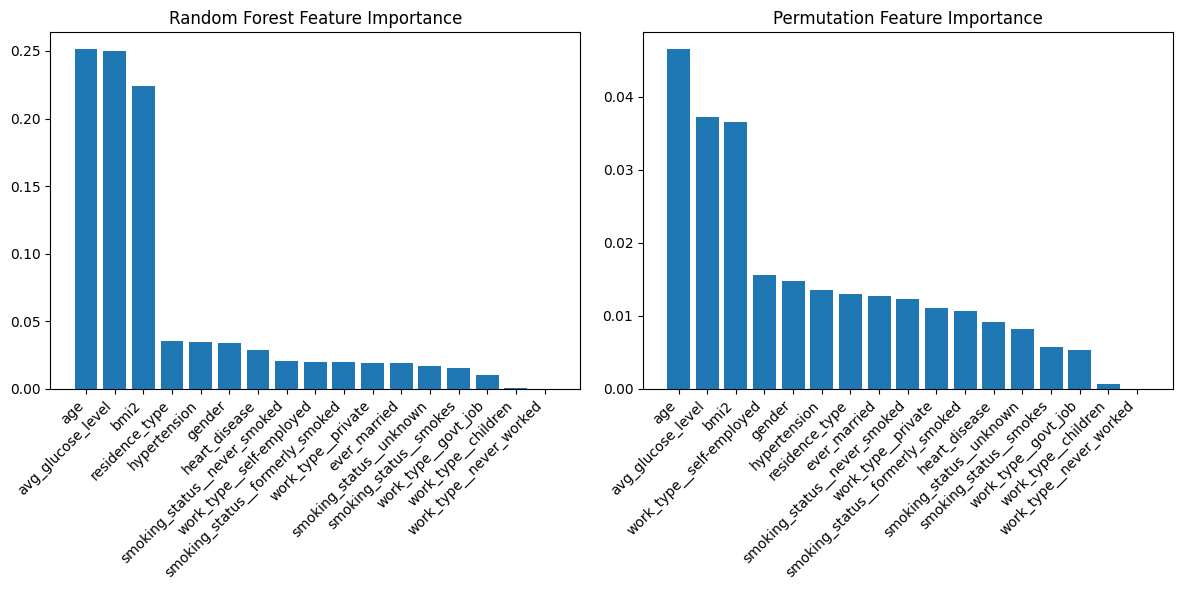

In [22]:
# Compute permutation importance
perm_importance = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)

# Plot feature importance comparison
plt.figure(figsize=(12, 6))

# Plot Random Forest feature importance
plt.subplot(1, 2, 1)
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[sorted_indices], tick_label=np.array(X_train.columns)[sorted_indices])
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Feature Importance')

# Plot Permutation importance
plt.subplot(1, 2, 2)
perm_sorted_indices = np.argsort(perm_importance.importances_mean)[::-1]
plt.bar(range(len(perm_importance.importances_mean)), perm_importance.importances_mean[perm_sorted_indices],
        tick_label=np.array(X_train.columns)[perm_sorted_indices])
plt.xticks(rotation=45, ha='right')
plt.title('Permutation Feature Importance')

plt.tight_layout()
plt.show()


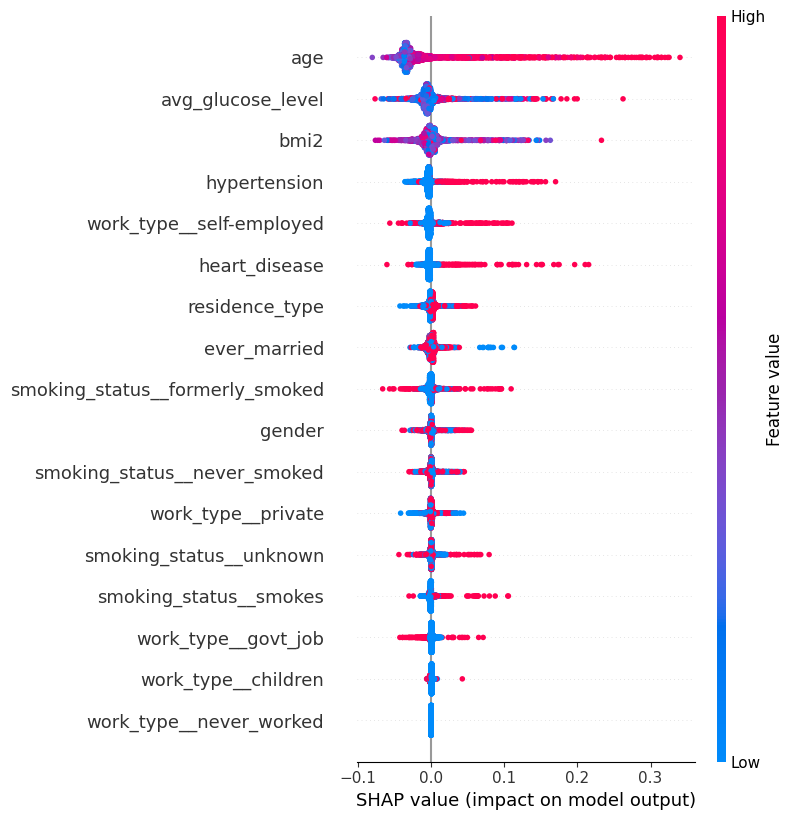

In [23]:
# Create a SHAP explainer object for your Random Forest model
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for your training data
shap_values = explainer.shap_values(X_train)

# For binary classification, shap_values[1] gives you SHAP values for class 1
# Now, shap_values[1] has a shape of (2682, 17), which matches X_train

# Plot SHAP summary plot for the positive class (class 1)
shap.summary_plot(shap_values[:,:,1], X_train)
